### Predicting Market crashes with topology in python
#### Beyond Traditional Indicators for Isights Into Market Behavior
https://medium.com/@crisvelasquez/predicting-stock-market-crashes-with-topological-data-analysis-in-python-1dc4f18ca7ca

[PH(D) = {[b,d]| b is birth time, d is death time of a feature in data D}]

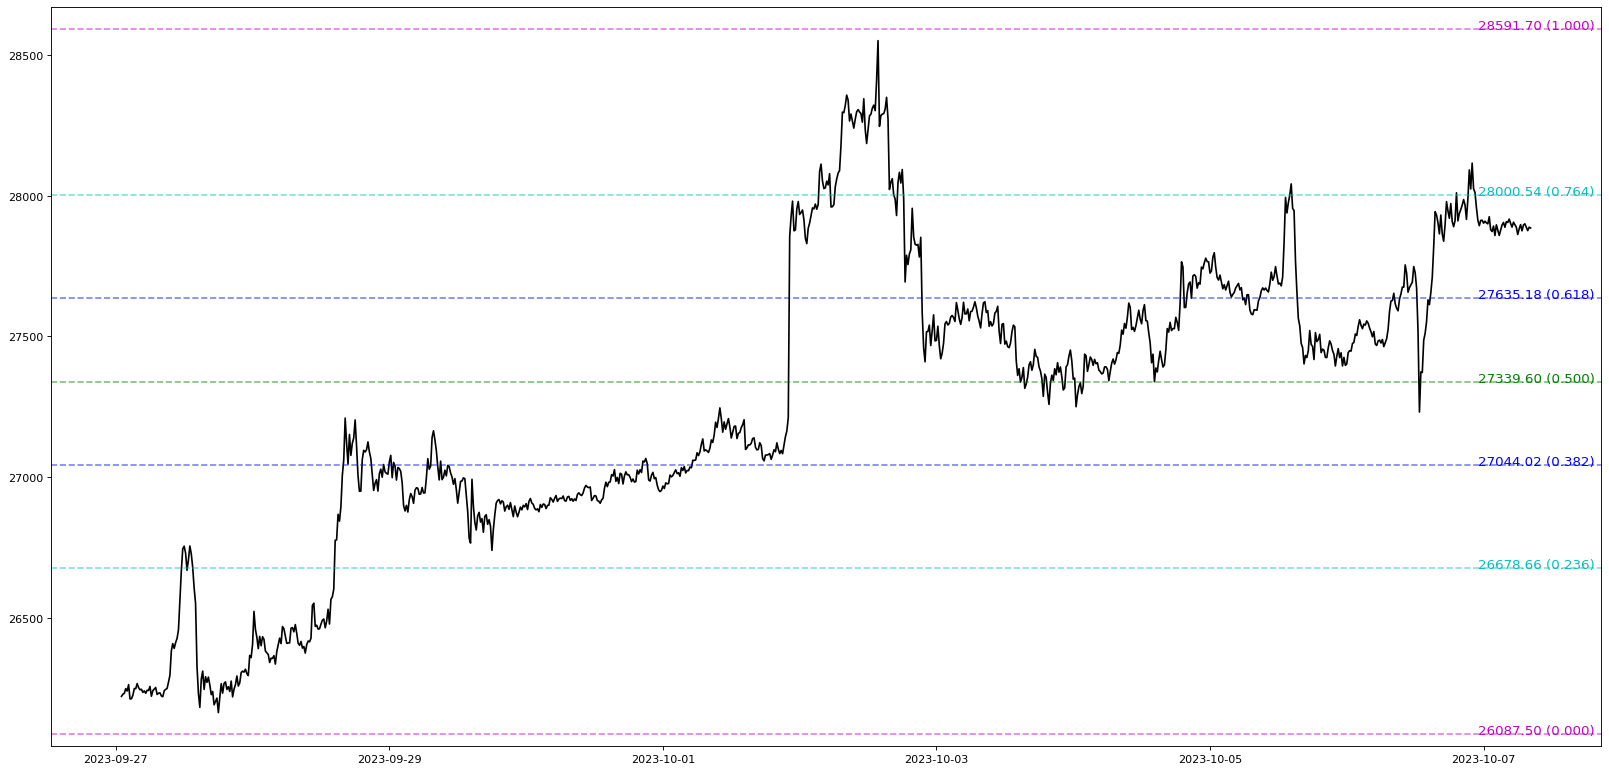

In [10]:
%matplotlib inline

import numpy as np 
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from matplotlib import style
import matplotlib.colors as mcolors
import yfinance as yf
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
import ccxt 

stock_name = 'BTC/USDT:USDT'

time_frame = '15m'        #1m, 15m, 1h, 4h, 6h, 12h, 1d, 1w, 1M
num_data = 990     # 7.14  12:00 ..... 709 (1h)//





#quandl.get("USTREASURY/REALYIELD")

start_date_INPUT = "2023-01-01"

binance = ccxt.bybit()
btc_ohlcv2 = binance.fetch_ohlcv(stock_name, time_frame, limit=num_data)
df2 = pd.DataFrame(btc_ohlcv2, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df2['datetime'] = pd.to_datetime(df2['datetime'], unit='ms')
df2.set_index('datetime', inplace=True)

price_x = df2.index 
prices = df2["close"].values

middle_line = (max(df2["high"]) + min(df2["low"]))/2
open_line = max(df2["high"])
close_line = min(df2["low"])

line_764 = max(df2["high"])-(max(df2["high"])-min(df2["low"]))*0.236068
line_618 = min(df2["low"])+(max(df2["high"])-min(df2["low"]))*0.618034
line_382 = max(df2["high"])-(max(df2["high"])-min(df2["low"]))*0.618034
line_236 = min(df2["low"])+(max(df2["high"])-min(df2["low"]))*0.236068


plt.subplots(1, 1, figsize=(25, 12), dpi=80)
plt.plot(price_x, prices, color='k')

plt.axhline(middle_line, linestyle='--', color = 'green', alpha = 0.5)
plt.axhline(open_line, linestyle='--', color = 'm', alpha = 0.5)
plt.axhline(close_line, linestyle='--', color = 'm', alpha = 0.5)
    
plt.axhline(line_764, linestyle='--', color = 'c', alpha = 0.5)
plt.axhline(line_618, linestyle='--', color = 'blue', alpha = 0.5)
plt.axhline(line_382, linestyle='--', color = 'blue', alpha = 0.5)
plt.axhline(line_236, linestyle='--', color = 'c', alpha = 0.5)


plt.text(df2['close'].index[-38],middle_line, f"{middle_line:.2f} "+"(0.500)", fontsize = 12, color = 'green')
plt.text(df2['close'].index[-38],open_line,  f"{open_line:.2f} "+"(1.000)", fontsize = 12, color = 'm')
plt.text(df2['close'].index[-38],line_764,  f"{line_764:.2f} "+"(0.764)", fontsize = 12, color = 'c')
plt.text(df2['close'].index[-38],line_618,  f"{line_618:.2f} "+"(0.618)", fontsize = 12, color = 'blue')
plt.text(df2['close'].index[-38],line_382,  f"{line_382:.2f} "+"(0.382)", fontsize = 12, color = 'blue')
plt.text(df2['close'].index[-38],line_236,  f"{line_236:.2f} "+"(0.236)", fontsize = 12, color = 'c')
plt.text(df2['close'].index[-38],close_line,  f"{close_line:.2f} "+"(0.000)", fontsize = 12, color = 'm')


log_returns = np.log(prices[1:]/prices[:-1])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


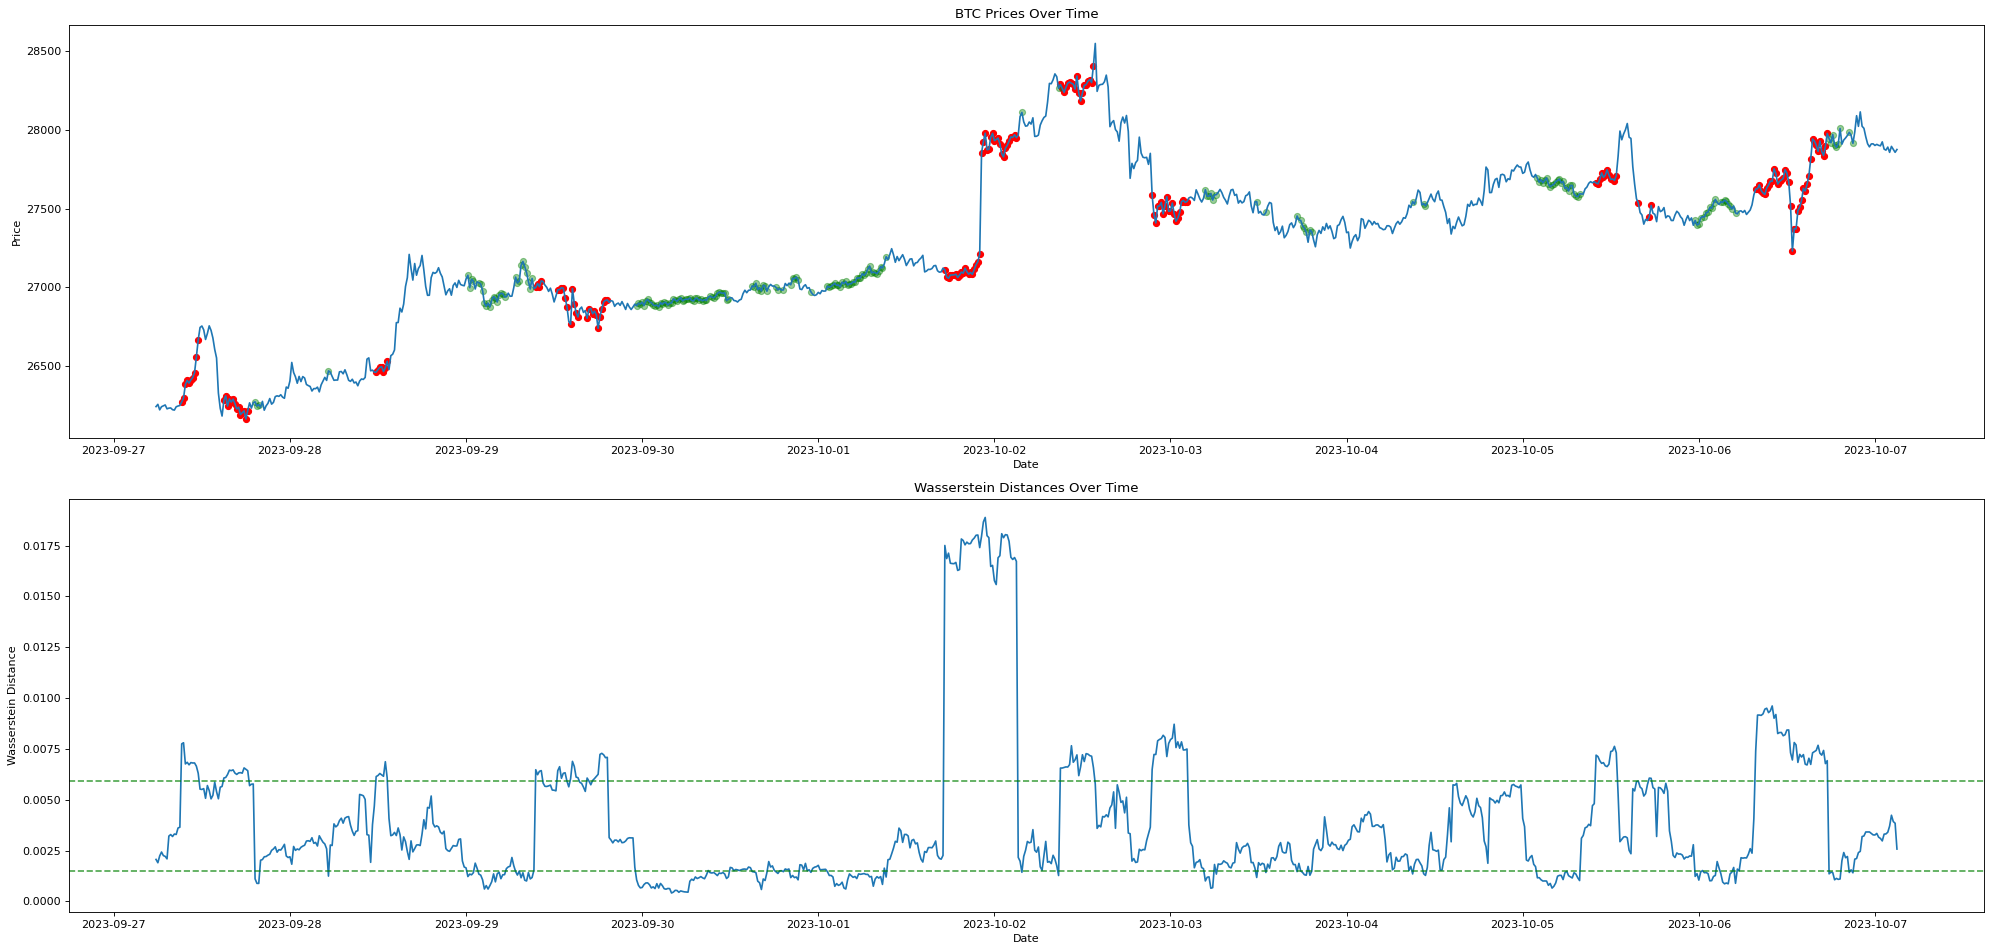

In [2]:
from ripser import Rips
import persim
rips = Rips()


window_size = 20
threshold = 0.0059

threshold_L = 0.0015

n = len(log_returns) - (2 * window_size) + 1
distances = np.full((n, 1), np.nan)  # Using np.full with NaN values

for i in range(n):
    segment1 = log_returns[i:i+window_size].reshape(-1, 1)
    segment2 = log_returns[i+window_size:i+(2*window_size)].reshape(-1, 1)

    if segment1.shape[0] != window_size or segment2.shape[0] != window_size:
        continue

    dgm1 = rips.fit_transform(segment1)
    dgm2 = rips.fit_transform(segment2)
    distance = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
    distances[i] = distance

dates = price_x[window_size:-window_size]




valid_indices = ~np.isnan(distances)
valid_dates = dates[valid_indices.flatten()]
valid_distances = distances[valid_indices]

alert_indices = [i for i, d in enumerate(valid_distances) if d > threshold]
alert_indices_L = [i for i, d in enumerate(valid_distances) if d < threshold_L]
alert_dates = [valid_dates[i] for i in alert_indices]
alert_dates_L = [valid_dates[i] for i in alert_indices_L]

alert_values = [df2["close"].iloc[i + window_size] for i in alert_indices]
alert_values_L = [df2["close"].iloc[i + window_size] for i in alert_indices_L]

fig, ax = plt.subplots(2, 1, figsize=(25, 12), dpi=80)
    
ax[0].plot(valid_dates, df2["close"].iloc[window_size:-window_size])
ax[0].scatter(alert_dates, alert_values, color='r', s=30)
ax[0].scatter(alert_dates_L, alert_values_L, alpha = 0.4,color='g', s=30)
ax[0].set_title('BTC Prices Over Time')
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Date')
    
ax[1].plot(valid_dates, valid_distances)
ax[1].set_title('Wasserstein Distances Over Time')
ax[1].set_ylabel('Wasserstein Distance')
ax[1].axhline(threshold, color='g', linestyle='--', alpha=0.7)
ax[1].axhline(threshold_L, color='g', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Date')

plt.tight_layout()
plt.show()
